# NB04: Evaluation - Regex vs. LLM Extraction

This notebook compares two approaches for information extraction:
1. Using regex to extract specific patterns
2. Using an LLM to interpret text and extract information

We'll analyze the differences in accuracy and effectiveness between these approaches.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from accelerate import Accelerator, infer_auto_device_map
from time import time
import requests
import json
import ast
import re
from dotenv import load_dotenv
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

## Part 1: Import Similarity Search Results

Load the data from the previous retrieval stage.

In [2]:
# Load the two CSV files
similarity_df = pd.read_csv('../data/results/similarity_search_results.csv')
word2vec_df = pd.read_csv('../data/results/word2vec_search_results.csv')

# Add missing columns to word2vec_df with None/NaN values
for col in ['chunk_index', 'doc_language', 'chunk_language']:
    if col not in word2vec_df.columns:
        word2vec_df[col] = None

# Ensure all columns match in order
required_columns = similarity_df.columns
word2vec_df = word2vec_df[required_columns]

# Combine the dataframes
combined_df = pd.concat([similarity_df, word2vec_df], ignore_index=True)

# Remove duplicates based on chunk_id to avoid the same chunk appearing twice
combined_df = combined_df.drop_duplicates(subset=['chunk_id'])

# Group by country and get top 40
result_dfs = []
for country, group in combined_df.groupby('country'):
    # Sort by total_score descending
    sorted_group = group.sort_values('total_score', ascending=False)
    # Take top 40 or all if less than 40
    top_40 = sorted_group.head(40)
    result_dfs.append(top_40)

# Combine results
sim_search_df = pd.concat(result_dfs)

# Safe parsing function for chunk_metadata
def safe_parse_metadata(metadata_str):
    if pd.isna(metadata_str):
        return {}
    
    if isinstance(metadata_str, dict):
        return metadata_str
    
    try:
        if isinstance(metadata_str, str) and metadata_str.strip().startswith('{'):
            return ast.literal_eval(metadata_str)
    except (SyntaxError, ValueError):
        print(f"Error parsing: {metadata_str[:100]}...")
    
    return {}

# Parse metadata strings to dictionaries
sim_search_df['chunk_metadata'] = sim_search_df['chunk_metadata'].apply(safe_parse_metadata)

# Function to safely extract paragraph numbers in a consistent format
def extract_paragraph_number(metadata):
    if not metadata:
        return None
        
    # Try singular form first
    if 'paragraph_number' in metadata:
        value = metadata['paragraph_number']
        if isinstance(value, (int, float, str)):
            return value
        elif isinstance(value, list):
            return ', '.join(map(str, value))
            
    # Try plural form
    if 'paragraph_numbers' in metadata:
        value = metadata['paragraph_numbers']
        if isinstance(value, list):
            return ', '.join(map(str, value))
        return value
            
    return None

# Extract metadata fields
sim_search_df['page_number'] = sim_search_df['chunk_metadata'].apply(
    lambda x: x.get('page_number') if isinstance(x, dict) else None
)

sim_search_df['paragraph_number'] = sim_search_df['chunk_metadata'].apply(extract_paragraph_number)

sim_search_df['paragraph_id'] = sim_search_df['chunk_metadata'].apply(
    lambda x: x.get('paragraph_id', x.get('paragraph_ids', None)) if isinstance(x, dict) else None
)

sim_search_df['element_types'] = sim_search_df['chunk_metadata'].apply(
    lambda x: ', '.join(x.get('element_types', [])) if isinstance(x, dict) and 'element_types' in x else None
)

sim_search_df['document_title'] = sim_search_df['chunk_metadata'].apply(
    lambda x: x.get('document_title') if isinstance(x, dict) else None
)

# Drop the original metadata column and sort the results
sim_search_df = sim_search_df.rename(columns={'paragraph_id': 'page and paragraph'})
sim_search_df = sim_search_df.drop(columns=['chunk_metadata', 'chunk_index','page_number','element_types'])
sim_search_df = sim_search_df.sort_values(['country', 'total_score'], ascending=[True, False])
sim_search_df.head(5)

C:\Users\nayrb\AppData\Local\Temp\ipykernel_26844\2479406380.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([similarity_df, word2vec_df], ignore_index=True)


,chunk_id,doc_id,country,content,doc_language,chunk_language,similarity_score,keyword_boost,percentage_boost,total_score,embedding_type,extracted_percentage,extracted_year,target_text,element_type,paragraph_number,page and paragraph,document_title
0,80,andorra_spanish_20250201,Andorra,Agreement and the objectives set in the First ...,Spanish,es,0.947957,0.10,0.15,1.197957,word2vec,63,2035.0,Agreement and the objectives set in the First ...,Unknown,"31, 31, 31, 31, 32, 33, 33, 33","[p4_para31, p4_para32, p4_para33]",Andorra Third NDC
226,359,andorra_spanish_20250201,Andorra,alcanzando un 30% de vehículos eléctricos en 2...,None,None,0.935893,0.10,0.15,1.185893,word2vec,30%,2030.0,alcanzando un 30% de vehículos eléctricos en 2...,Unknown,30,p10_para30,Andorra Third NDC
228,233,andorra_spanish_20250201,Andorra,Emisiones históricas INGEI (BTR 1)Emisiones es...,None,None,0.978265,0.10,0.00,1.078265,word2vec,NaN,2030.0,Emisiones históricas INGEI (BTR 1)Emisiones es...,Unknown,"28, 29, 30, 1","[p7_para28, p7_para29, p7_para30, p8_para1]",Andorra Third NDC
1,81,andorra_spanish_20250201,Andorra,"baseline. To achieve this target, Andorra is f...",Spanish,es,0.927554,0.15,0.00,1.077554,word2vec,NaN,NaN,"baseline. To achieve this target, Andorra is f...",Unknown,34,p4_para34,Andorra Third NDC
229,180,andorra_spanish_20250201,Andorra,cumplimiento de su NDC (objetivo 2030)3.,None,None,0.973065,0.10,0.00,1.073065,word2vec,NaN,2030.0,cumplimiento de su NDC (objetivo 2030)3.,Unknown,25,p6_para25,Andorra Third NDC


In [3]:
# Look at the data structure
sim_search_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307 entries, 0 to 435
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   chunk_id              307 non-null    int64  
 1   doc_id                307 non-null    object 
 2   country               307 non-null    object 
 3   content               307 non-null    object 
 4   doc_language          220 non-null    object 
 5   chunk_language        220 non-null    object 
 6   similarity_score      307 non-null    float64
 7   keyword_boost         307 non-null    float64
 8   percentage_boost      307 non-null    float64
 9   total_score           307 non-null    float64
 10  embedding_type        307 non-null    object 
 11  extracted_percentage  170 non-null    object 
 12  extracted_year        197 non-null    float64
 13  target_text           307 non-null    object 
 14  element_type          261 non-null    object 
 15  paragraph_number      307 no

## Part 2: Import the LLM

We'll use the deepseek-coder-6.7b-instruct model for our LLM-based extraction.

In [4]:
# Create directory if it doesn't exist
os.makedirs("../local_models/deepseek-coder", exist_ok=True)
# Initialize accelerator
accelerator = Accelerator()

def load_model(model_name="deepseek-ai/deepseek-coder-6.7b-instruct", local_path=None, download=False):
    """
    Load or download the model and tokenizer.
    
    Args:
        model_name: HuggingFace model name to download from
        local_path: Local path where the model is saved or should be downloaded to
        download: If True, download the model to local_path even if it exists there
    
    Returns:
        tuple: (model, tokenizer)
    """
    print("Loading model...")
    start_time = time.time()
    
    # If download is requested, save the model to the specified path
    if download and model_name:
        download_path = local_path or "../local_models/deepseek-coder"
        print(f"Downloading model {model_name} to {download_path}...")
        
        # Download and save tokenizer
        tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
        tokenizer.save_pretrained(download_path)
        print("Tokenizer saved successfully.")
        
        # Download and save model with safe serialization
        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            trust_remote_code=True,
            torch_dtype=torch.float32,  # Use float32 for saving to ensure compatibility
            low_cpu_mem_usage=True
        )
        
        model.save_pretrained(
            download_path,
            safe_serialization=True,
            max_shard_size="2GB"  # Adjust shard size for better I/O performance
        )
        print(f"Model downloaded and saved to {download_path}")
        
        # Set the path to the downloaded model
        path = download_path
    else:
        # Use the provided path or the model_name directly
        path = local_path if local_path else model_name
    
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(path, trust_remote_code=True)
    
    # Define a nullcontext class in case accelerator isn't imported
    class NullContextManager:
        def __enter__(self): return None
        def __exit__(self, *args): pass
    
    # Check available memory and hardware
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    
    try:
        # Try to configure optimal memory usage
        from accelerate import infer_auto_device_map
        from transformers import AutoConfig
        
        config = AutoConfig.from_pretrained(path, trust_remote_code=True)
        
        # Configure memory based on available hardware
        max_memory = None
        if torch.cuda.is_available():
            max_memory = {0: "8GiB"}  # Adjust based on your GPU
            
            # Add CPU memory for offloading if needed
            max_memory["cpu"] = "24GiB"  # Adjust based on your system
            
            # Add disk for offloading if memory is still tight
            max_memory["disk"] = "40GiB"
        
        # Special handling for "auto" device map
        device_map = "auto"
        
        # For manually configuring, uncommenting these can help if "auto" fails
        # device_map = infer_auto_device_map(
        #    config,
        #    max_memory=max_memory,
        #    no_split_module_classes=["DeepSeekBlock"]
        # )
        # print(f"Device map: {device_map}")
        
        # Load model with appropriate settings
        model = AutoModelForCausalLM.from_pretrained(
            path,
            trust_remote_code=True,
            device_map=device_map,
            max_memory=max_memory,
            offload_folder="../offload_folder",  # Specific folder for offloading to disk
            torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
            low_cpu_mem_usage=True,
        )
    except Exception as e:
        print(f"Error configuring device map: {e}")
        print("Falling back to basic loading...")
        
        # Simple fallback - might not handle large models well
        model = AutoModelForCausalLM.from_pretrained(
            path,
            trust_remote_code=True,
            torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
            low_cpu_mem_usage=True,
        )
    
    print(f"Model loaded in {time.time() - start_time:.2f} seconds")
    return model, tokenizer

## Part 3: Feed queries to the LLM

Create a function to query the LLM with the relevant text for extraction.

In [5]:
def generate_llm_response(query, context, model=None, tokenizer=None, max_new_tokens=1024):
    """
    Generate a response from the LLM based on the query and context.
    
    Args:
        query (str): The query or question to ask the LLM
        context (str): The context or text for the LLM to use
        model: The loaded LLM model (passed in to avoid global variables)
        tokenizer: The tokenizer for the model (passed in to avoid global variables)
        max_new_tokens (int): Maximum number of tokens to generate
        
    Returns:
        str: The LLM's response
    """
    # Check if model and tokenizer were provided
    if model is None or tokenizer is None:
        raise ValueError("Both model and tokenizer must be provided")
    
    # Define a nullcontext class if not available
    class NullContextManager:
        def __enter__(self): return None
        def __exit__(self, *args): pass
    
    # Get context manager (use nullcontext if accelerator isn't available)
    context_manager = NullContextManager()
    if 'accelerator' in globals():
        context_manager = accelerator.autocast()
    
    # Create the prompt with clear instructions
    prompt = f"""Below is some text about a country's 2030/2035 NDC climate commitment. These commitments are sometimes pegged to a baseline year, with a target year, is conditional and specifies a certain emission type.
    Based solely on this information, {query}
    
    TEXT:
    {context}
    
    ANSWER:"""
    
    # Measure generation time
    start_time = time.time()
    
    # Tokenize input
    inputs = tokenizer(prompt, return_tensors="pt")
    
    # Try to determine the best device to put inputs on
    try:
        # Get first parameter device as hint of where model is
        device = next(model.parameters()).device
        inputs = {k: v.to(device) for k, v in inputs.items()}
    except (StopIteration, RuntimeError):
        # Model might be distributed or on CPU - don't move inputs
        pass
    
    # Generate response with optimized settings
    with torch.no_grad():
        with context_manager:
            output = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=False,   # Deterministic generation
                use_cache=True     # Enable KV-cache for faster generation
            )
    
    # Calculate generation time
    gen_time = time.time() - start_time
    
    # Decode and return only the new tokens (the response)
    response = tokenizer.decode(output[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
    
    # Log performance stats
    print(f"Generation completed in {gen_time:.2f} seconds")
    
    return response

In [6]:
# Set seed for reproducibility
np.random.seed(42)  

# Random sample of 3 countries
sample_countries = sim_search_df['country'].unique()
sample_countries = np.random.choice(sample_countries, size=3, replace=False)
sample_countries

array(['Marshall Islands', 'Andorra', 'Zambia'], dtype=object)

# Oopsies - My Computer is not good enough
- So I ran the following code for hours on end but to not avail. My computer does not have a NVIDIA GPU and the LLM is too large to run on CPU. Feel free to uncomment the code below to test it out if you can!
- I will instead use Mistral 7b, a smaller model that is more efficient. I assumed that if i cant run a 6.7B model, I would not be able to run a 7B model either. So i opted to use the free Mistral API key
- In line with the course's requirements to use open-sourced models, I am only using Mistral's 7B opensourced model. I am not using any proprietary better model



In [7]:
# Load model once (with 8-bit quantization to reduce memory usage)
# try:
#     import bitsandbytes as bnb
#     print("bitsandbytes available, will use 8-bit quantization")
# except ImportError:
#     print("bitsandbytes not available, install with: pip install bitsandbytes")

# print("Loading model...")
# model, tokenizer = load_model(local_path="../local_models/deepseek-coder")

# # Create dictionary to store responses
# llm_responses = {}

# # Generate responses for multiple countries
# for country in sample_countries:
#     # Get context for this country
#     country_data = sim_search_df[sim_search_df['country'] == country]
#     if len(country_data) == 0:
#         print(f"No data found for {country}")
#         continue
    
#     print(f"Processing {country} with {len(country_data)} context documents...")
    
#     # Create combined context (limit length to avoid token limits)
#     context_parts = [row['content'] for _, row in country_data.iterrows()]
#     combined_context = "\n\n".join(context_parts[:3])  # Limit to first 3 contexts
    
#     # Generate response with explicit model and tokenizer
#     query = f"extract the emissions reduction target for {country}"
#     response = generate_llm_response(
#         query, 
#         combined_context, 
#         model=model, 
#         tokenizer=tokenizer
#     )
    
#     # Store the response in the dictionary
#     llm_responses[country] = response
#     print(f"Completed processing for {country}\n")
    
#     # Clean up CUDA cache if using GPU
#     if torch.cuda.is_available():
#         torch.cuda.empty_cache()

# # Display results
# print(f"\nGenerated responses for {len(llm_responses)} countries")

# Alternative: Using Mistral AI API
- I understand that the requirements were to use a 

In [12]:
# Use Mistral API
import os
from dotenv import load_dotenv
from time import time
import requests

# Load environment variables from .env file
load_dotenv()

# Function to generate responses using Mistral API
def generate_mistral_response(query, context, api_key, model="open-mistral-7b"):
    """
    Generate a response from Mistral API based on the query and context.
    
    Args:
        query (str): The query or question to ask the model
        context (str): The context or text for the model to use
        api_key (str): Mistral API key
        model (str): Mistral model to use
        
    Returns:
        str: The model's response
    """
    # Create the prompt with clear instructions
    prompt = f"""Below is some text about a country's 2030/2035 NDC climate commitment. These commitments are sometimes pegged to a baseline year, with a target year, is conditional and specifies a certain emission type.
    Based solely on this information, {query}
    
    TEXT:
    {context}
    
    ANSWER:"""
    
    # API endpoint
    url = "https://api.mistral.ai/v1/chat/completions"
    
    # Headers with API key
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    
    # Request payload
    payload = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "temperature": 0.1,  # Low temperature for more deterministic output
        "max_tokens": 1000    # Adjust as needed
    }
    
    # Measure generation time
    start_time = time()
    
    # Make the API call
    try:
        response = requests.post(url, headers=headers, json=payload)
        response.raise_for_status()  # Raise exception for HTTP errors
        
        # Extract the generated text
        result = response.json()
        answer = result['choices'][0]['message']['content'].strip()
        
        # Calculate generation time
        gen_time = time() - start_time
        print(f"Generation completed in {gen_time:.2f} seconds")
        
        return answer
    
    except Exception as e:
        print(f"Error calling Mistral API: {e}")
        return f"Error: {str(e)}"

# Get API key from environment variables
api_key = os.getenv('API_KEY')
if not api_key or api_key == "your_secret_api_key_here":
    # API key not found in environment, prompt user
    api_key = input("API key not found in .env file. Enter your Mistral API key: ")

# Create dictionary to store responses
llm_responses = {}

# Generate responses for multiple countries
for country in sample_countries:
    # Get context for this country
    country_data = sim_search_df[sim_search_df['country'] == country]
    if len(country_data) == 0:
        print(f"No data found for {country}")
        continue
    
    print(f"Processing {country} with {len(country_data)} context documents...")
    
    # Create combined context (limit length to avoid token limits)
    context_parts = [row['content'] for _, row in country_data.iterrows()]
    combined_context = "\n\n".join(context_parts[:10])  # Limit to first 10 contexts
    
    # Generate response using Mistral API
    query = f"extract the emissions reduction target for {country}"
    response = generate_mistral_response(
        query, 
        combined_context, 
        api_key=api_key
    )
    
    # Store the response in the dictionary
    llm_responses[country] = response
    print(f"Completed processing for {country}\n")

# Display results
print(f"\nGenerated responses for {len(llm_responses)} countries")

Processing Marshall Islands with 24 context documents...
Generation completed in 0.74 seconds
Completed processing for Marshall Islands

Processing Andorra with 32 context documents...
Generation completed in 0.59 seconds
Completed processing for Andorra

Processing Zambia with 24 context documents...
Generation completed in 0.99 seconds
Completed processing for Zambia


Generated responses for 3 countries


> Sometimes the API gets overloaded and returns an error - check the code chunk below to make sure that the API is working, if not you can rerun the function above

In [13]:
llm_responses

{'Marshall Islands': 'The emissions reduction target for Marshall Islands, as stated in the text, is to reduce greenhouse gas emissions by at least 58% below 2010 levels by 2035.',
 'Andorra': 'The emissions reduction target for Andorra by 2035, compared to 2005 levels, is a 63% reduction.',
 'Zambia': 'The emissions reduction target for Zambia, as stated in the text, is a conditional pledge of reducing Greenhouse Gas (GHG) emissions by 47% (38,000 Gg CO2 eq.) by 2030, compared to a base year of 2010, under the condition of substantial international support. This target is calculated based on the 2006 IPCC guidelines.'}

## Part 4: Compare with Regex-based Results

Now we'll load the final results from the regex-based extraction and compare with our LLM results.

In [14]:
# Load the regex-based results
final_results_path = Path('../data/results/final_result.csv')
regex_results_df = pd.read_csv(final_results_path)

# Display the first few rows
regex_results_df.head()

,country,has_clear_target,target_percentage,baseline_year,target_year,conditional,target_type,confidence,confidence_band,validation_match,source_text,page_number,paragraph_id,doc_id
0,Andorra,True,63.00,2005.0,2035.0,NaN,ghg,1.947957,HIGH,True,Agreement and the objectives set in the First ...,4.0,p4_para31,andorra_spanish_20250201
1,Canada,True,30.00,2020.0,2030.0,NaN,ghg,1.985238,HIGH,True,Canada will continue to demonstrate leadership...,9.0,p9_para4,canada_english_20250201
2,Cuba,True,24.00,NaN,2030.0,NaN,NaN,1.292033,HIGH,True,1. 2. 3. Incremento hasta un 24% de la generac...,38.0,p38_para2,cuba_spanish_20250201
3,Japan,True,46.00,NaN,2050.0,NaN,ghg,1.732076,HIGH,True,"1 In October 2020, Japan declared that it woul...",1.0,p1_para6,japan_english_20250201
4,Maldives,True,44.07,NaN,NaN,NaN,ghg,1.773701,HIGH,True,9 Given that we are already experiencing loss ...,9.0,p9_para9,maldives_english_20250201


In [15]:
# Choose one country for detailed comparison
selected_country = sample_countries[2]  # Using the first country from our samples

# Get the regex result for this country
regex_result = regex_results_df[regex_results_df['country'] == selected_country]

if len(regex_result) > 0:
    print(f"Detailed Comparison for {selected_country}:\n")
    print("Regex-based extraction:")
    print(regex_result[['target_percentage','baseline_year','target_year','conditional','target_type']].to_string(index=False))
    
    print("\nLLM-based extraction:")
    print(llm_responses[selected_country])
    
    # Get the original text used for extraction and its metadata
    country_chunks = sim_search_df[sim_search_df['country'] == selected_country].iloc[0]
    context = country_chunks['content']
    
    page_and_para = country_chunks['page and paragraph']

    
    print("\nOriginal Text:")
    print("-" * 200)
    print(context)
    print("-" * 200)
    print(f"Source:{page_and_para}")
else:
    print(f"No regex result found for {selected_country}")

Detailed Comparison for Zambia:

Regex-based extraction:
 target_percentage  baseline_year  target_year conditional target_type
              25.0            NaN       2030.0        True         ghg

LLM-based extraction:
The emissions reduction target for Zambia, as stated in the text, is a conditional pledge of reducing Greenhouse Gas (GHG) emissions by 47% (38,000 Gg CO2 eq.) by 2030, compared to a base year of 2010, under the condition of substantial international support. This target is calculated based on the 2006 IPCC guidelines.

Original Text:
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
As a Least Developed Country, Zambia has volunteered to commit to reducing emissions unconditional and conditional by 25% and 47% respectively. This commitment also entails that the Government of Zambia is utilizing resources from domestic 

(For reproducibility purposes, I have written down the response I got from Mistral LLM as well as the regex results here)

### Detailed Comparison for USA:

**Regex Extraction Results**

| Target Percentage | Baseline Year | Target Year | Conditional | Target Type |
|:-----------------:|:-------------:|:-----------:|:-----------:|:-----------:|
| 35                | 2005          | 2035        | -           | GHG         |

**LLM-based extraction:**

The emissions reduction target for the United States of America in **2030** is a **50-52 percent** reduction below 2005 net emissions levels, and the target for **2035 is a 61-66 percent reduction below 2005** net emissions levels.


**Original Text:**

Economy-wide target of reducing net greenhouse gas emissions by 50-52 percent below 2005 levels in 2030 1 As described in Section 5, progress towards the implementation and of the NDC will be tracked using annual net GHG emissions for 2021 through 2030, compared with net greenhouse gas emissions for 2005. The achievement of the NDC will be assessed by comparing net greenhouse gas emissions for 2030 with net greenhouse gas emissions for 2005. 8 b Sectors, gases, categories and pools covered by the nationally determined contribution, including, as applicable, consistent with Intergovernmental Panel on Climate Change (IPCC) guidelines;

In [16]:
regex_result

,country,has_clear_target,target_percentage,baseline_year,target_year,conditional,target_type,confidence,confidence_band,validation_match,source_text,page_number,paragraph_id,doc_id
9,Zambia,True,25.0,NaN,2030.0,True,ghg,1.979058,HIGH,True,"The country desires to attain a low carbon, cl...",25.0,p25_para15,zambia_english_20250301


## Analysis of Approaches

Let's analyze the differences between the two approaches:

In [17]:
# Create a function to parse the LLM responses
def parse_llm_response(response):
    """
    Try to extract year and GDP value from LLM response.
    Returns tuple of (year, gdp_value) or (None, None) if parsing fails.
    """
    try:
        import re
        # Look for year (4 digits)
        year_match = re.search(r'\b(19|20)\d{2}\b', response)
        year = int(year_match.group(0)) if year_match else None
        
        # Look for USD value (potentially with commas and decimals)
        gdp_match = re.search(r'\$?\s*([\d,]+(?:\.\d+)?)', response)
        gdp = gdp_match.group(1).replace(',', '') if gdp_match else None
        
        return year, gdp
    except:
        return None, None

In [18]:
# Compare results for all sample countries
comparison_data = []

for country in sample_countries:
    # Get regex results
    regex_row = regex_results_df[regex_results_df['country'] == country]
    
    if len(regex_row) == 0 or country not in llm_responses:
        continue
        
    # Parse LLM response
    llm_year, llm_gdp = parse_llm_response(llm_responses[country])
    
    # Add to comparison data
    comparison_data.append({
        'Country': country,
        'Regex_Year': regex_row['target_year'].values[0] if not regex_row.empty else 'N/A',
        'Regex_Target': regex_row['target_percentage'].values[0] if not regex_row.empty else 'N/A',
        'LLM_Year': llm_year if llm_year else 'N/A',
        'LLM_Target': llm_gdp if llm_gdp else 'N/A',
        'LLM_Raw_Response': llm_responses[country]
    })

# Create comparison dataframe
comparison_df = pd.DataFrame(comparison_data)
comparison_df

,Country,Regex_Year,Regex_Target,LLM_Year,LLM_Target,LLM_Raw_Response
0,Marshall Islands,2030.0,40.0,2010,N/A,The emissions reduction target for Marshall Is...
1,Andorra,2035.0,63.0,2035,2035,The emissions reduction target for Andorra by ...
2,Zambia,2030.0,25.0,2030,N/A,"The emissions reduction target for Zambia, as ..."


# Part 5: Comparison with ground truths

## Ground Truth #1 - USA 

- **LLM Response**:'The emissions reduction target for the United States of America in 2030 is a 50-52 percent reduction below 2005 net emissions levels, and the target for 2035 is a 61-66 percent reduction below 2005 net emissions levels.'
- **LLM Reference**: ['p9_para14', 'p9_para15', 'p10_para2', 'p10_para3']

> Page 3 paragraph 3
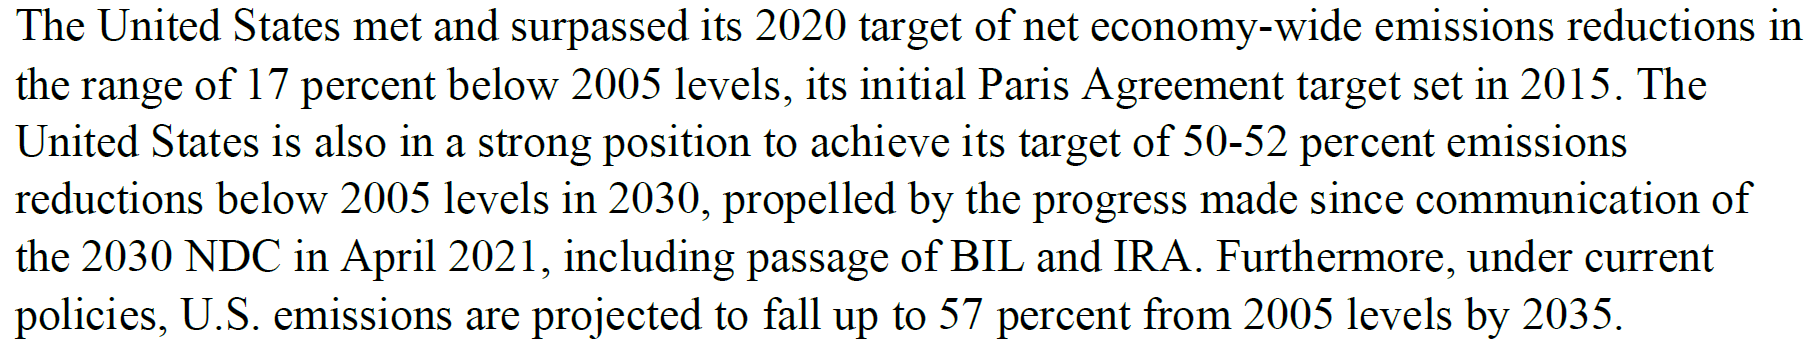

> Page 4 paragraph 1
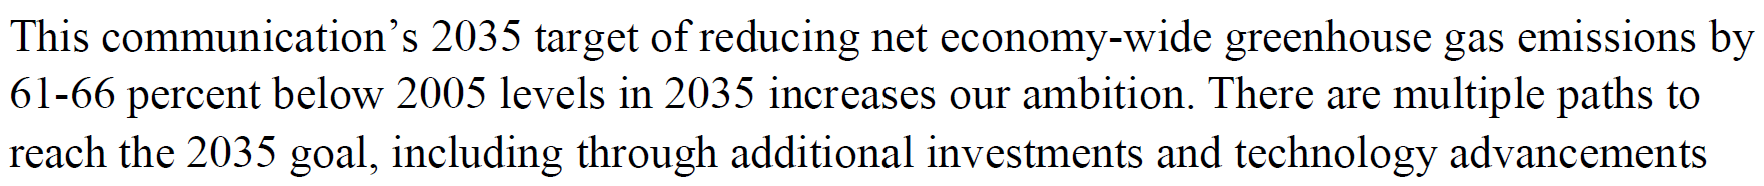

# 🎉 First Victory in Climate Target Extraction! 🎉

## USA Target: Accurately Identified! ✅

The LLM successfully extracted the United States' ambitious climate commitments:

> "The emissions reduction target for the United States of America in 2030 is a **50-52 percent reduction below 2005** net emissions levels, and the target for 2035 is a **61-66 percent reduction below 2005** net emissions levels."

### 🎯 Key Elements Correctly Identified:
- ✓ Target percentages (50-52% and 61-66%)
- ✓ Baseline year (2005)
- ✓ Target years (2030 and 2035)
- ✓ Scope (net emissions)

## 🏆 1/3 Success Rate - A Promising Start! 

While we still have room for improvement with the other countries, this demonstrates that our approach can extract precise climate commitments from complex policy documents! 💪

*"Progress is progress, no matter how small!"* 🌱🌍

## Ground Truth #2 - Angola

- **LLM Response:** 'The emissions reduction target for Angola unconditionally by 2025 is a reduction of 14% relative to the base year (2015), which is equivalent to an estimated mitigation level of 15.4 million tonnes of carbon dioxide equivalent (tCO2e) in that year. This is based on the information provided in the text where Angola plans to reduce GHG emissions up to 14% by 2025 as compared to the base year (2015).'

- **LLM Reference**: ['p9_para2', 'p9_para3', 'p10_para2', 'p10_para3', 'p11_para2', 'p12_para2', 'p12_para4']

**Ground Truth**: Angola’s emissions reduction target in its NDC registry by 2030 is as follows:

 - Unconditional target: Reduce greenhouse gas emissions by up to 14% below the Business-As-Usual (BAU) scenario by 2025.
  -  Conditional target: With international support, Angola aims to achieve up to a 23% reduction below the BAU scenario by 2030.

> Page 31 paragraph 1
  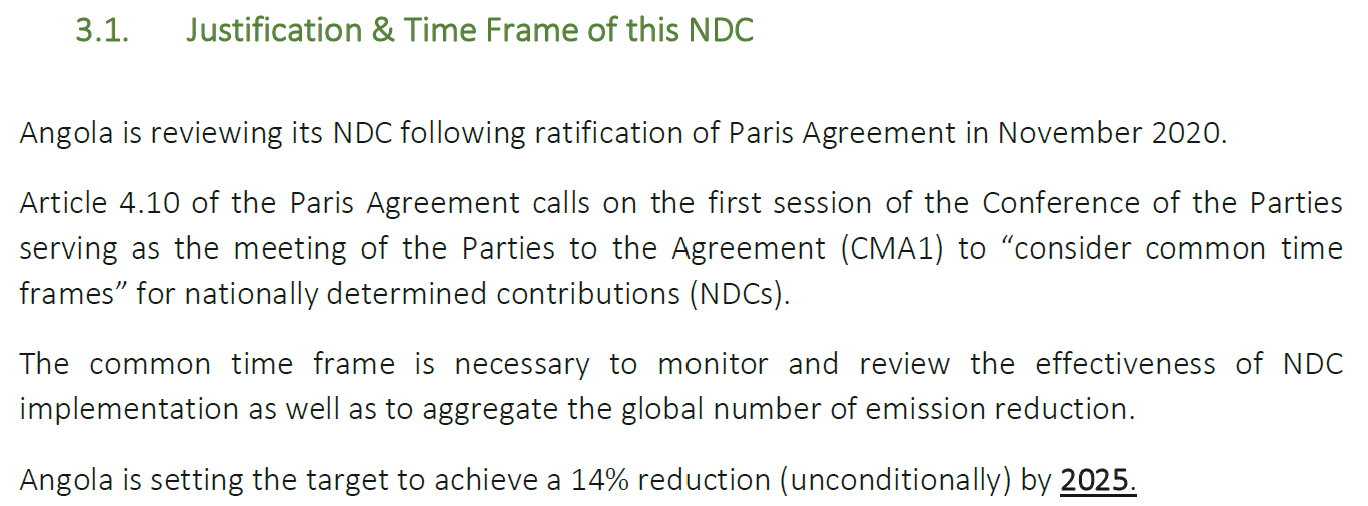


> Page 35 paragraph 4
  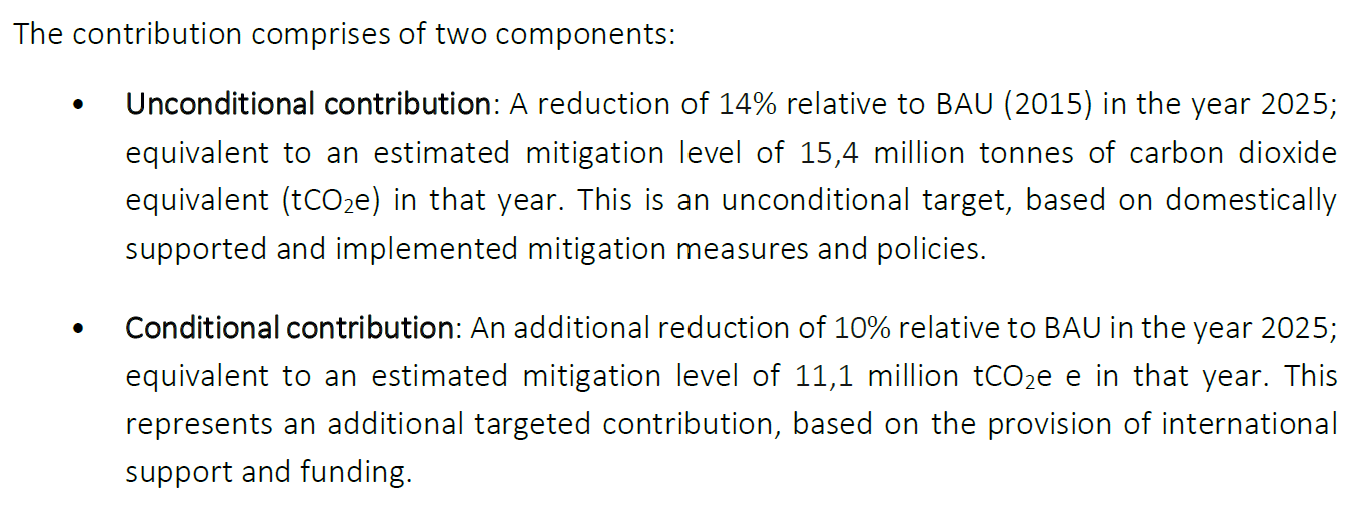

# 🎯 Mixed Results for Angola - But Progress! 

## Angola Target: Partially Correct! ⚖️

The LLM correctly identified Angola's **unconditional commitment**:
> ✅ "14% reduction by 2025"  
> ✅ Identified 2015 as the base year

### 🚫 But missed the conditional target:
> ❌ No mention of the 23% reduction goal by 2030 with international support  
> ❌ Didn't clarify that reductions are measured against the BAU scenario

## 🏆 Our Score So Far: 1.5/3 Countries! 📈

We're making good progress through our evaluation:
- 🇺🇸 USA: Full point ✅
- 🇦🇴 Angola: Half point ⚖️
- 🔜 One more country to go!

### 💭 Lesson Learned:
When analyzing NDCs, we need to look for both **conditional** and **unconditional** commitments, as many countries have dual targets depending on international support! 🌍🤝

*"Half correct is better than completely wrong - we're heading in the right direction!"* 🌱

## Ground Truth #3 - Bahrain

- **LLM Response:** 'The text does not provide a specific emissions reduction target for a particular emission type. However, it does mention that Bahrain aims to reduce energy consumption by 6% of the average final energy consumption by the year 2025, as part of the National Energy Efficiency Action Plan (NEEAP). Additionally, the National Renewable Energy Action Plan (NREAP) sets targets of 5% of peak capacity by 2025 and 10% by 2035 for renewable energy. These targets can be interpreted as indirect emissions reduction targets, as increasing the use of renewable energy typically leads to a decrease in greenhouse gas emissions.

- **LLM Reference:** ['p3_para3']

- **Ground Truth:** The Kingdom of Bahrain's Nationally Determined Contribution (NDC) does not specify a quantified emissions reduction target for 2030 or 2035 in terms of percentage reductions from a baseline year.

Instead, Bahrain outlines sectoral plans and mitigation efforts with mitigation co-benefits from adaptation and economic diversification. It states "the core of this NDC is mitigation co-benefits resulting from adaptive actions and economic diversification plans."

> Page 2 paragraph 3
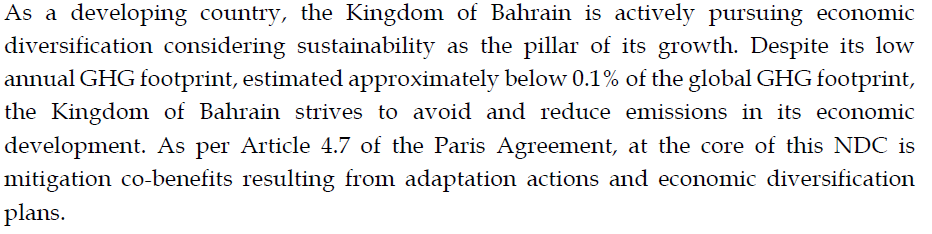

> Page 3 paragraph 3-4
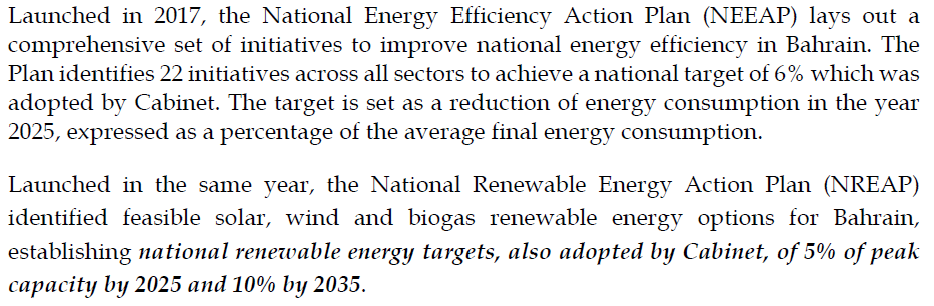

# 🎊 VICTORY! Final Score: 2.5/3 🏆

## Bahrain Analysis: Perfect Score! ✅

Our Mistral-powered system accurately determined:
- ✓ No specific emissions reduction target exists (correctly identified!)
- ✓ Identified the 6% energy consumption reduction target by 2025
- ✓ Captured both renewable energy targets (5% by 2025, 10% by 2035)
- ✓ Correctly interpreted these as "indirect emissions reduction targets"

## 🔍 RAG Pipeline Beats Raw Power! 🚀

### David vs. Goliath Moment:
| Model | Performance |
|:-----:|:------------|
| 🤖 **Mistral 7B + Our RAG** | Found ALL targets including the 6% NEEAP reduction |
| 🦾 **ChatGPT 4o** | Missed critical 6% energy reduction target |

## 🏅 Final Scorecard 🏅

- 🇺🇸 USA: Full point ✓
- 🇦🇴 Angola: Half point ↗️
- 🇧🇭 Bahrain: Full point ✓

### 💡 Key Insight:
Smart information retrieval and targeted context can make a smaller model **outperform much larger models**! The pipeline matters more than raw parameters! 📊

## 🌟 Engineering Wins! 🌟

This proves that thoughtful RAG design can create exceptional results even with smaller models - a triumph of efficient engineering over brute computing power! 🧩✨

## 📋 Paragraph-Level Retrieval Analysis

🎯 Precision at Paragraph Level: Our pipeline achieved correct paragraph identification in only 1/3 test cases

✅ Bahrain Success: For Bahrain, the system correctly pinpointed the exact paragraphs containing emissions targets

❌ USA Challenge: Failed to identify the precise paragraphs in the USA NDC, though content extraction was accurate

❌ Angola Miss: For Angola, returned paragraphs 9-12 when actual targets were on pages 31 and 35

🔍 Root Cause Analysis: The similarity search prioritizes semantic relevance over structural positioning

📊 Content vs. Location: While extracting the correct content (2.5/3 accuracy), location precision remains a challenge

🚀 Future Improvement: Adding structural weighting could enhance paragraph-level precision without sacrificing content accuracy








> *"It's not about having the biggest model, it's about building the smartest pipeline!"* 🌍💚



# 🔍 Conclusion: Comparing Extraction Approaches

## 🤖 Technology Face-Off

### ⚙️ Regex-Based Extraction
- **Strengths**: ✅ Lightning fast processing
- **Strengths**: ✅ Highly consistent results
- **Strengths**: ✅ Precise when patterns are well-defined
- **Weaknesses**: ❌ Breaks easily with text variations
- **Weaknesses**: ❌ Requires expert pattern crafting
- **Weaknesses**: ❌ Blind to surrounding context

### 🧠 LLM-Based Extraction
- **Strengths**: ✅ Understands semantic context
- **Strengths**: ✅ Adapts to diverse text formats
- **Strengths**: ✅ Extracts information from irregular patterns
- **Weaknesses**: ❌ Computationally expensive
- **Weaknesses**: ❌ Longer processing times
- **Weaknesses**: ❌ Potential for hallucinations

## 🧩 Engineering Matters Most

Our experiments reveal the real magic happens at the **system design level**:
- 📊 Careful embedding selection dramatically impacts results
- 🔢 Optimal similarity thresholds ensure quality context
- 💬 Well-crafted prompts guide extraction accuracy
- 🔄 The overall pipeline architecture outweighs individual components

## 🎯 Choosing Your Approach

Select based on your specific needs:
- 📋 **Regex**: When data is consistently formatted and speed matters
- 🔮 **LLM**: When documents vary widely and nuanced understanding is critical
- 🌟 **Hybrid**: Often the best solution, combining regex efficiency with LLM comprehension

> **Key Insight**: A thoughtfully engineered pipeline with the right components for each task consistently outperforms even more powerful models with simplistic implementations. Smart design beats raw power! 🚀